In [56]:
#General modules import
import numpy as np
import pandas as pd
import numpy.random as rd
from scipy import stats
import scipy as sc
import scipy.ndimage as ndimage

from math import gcd
from numpy import pi

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

import rebound as rb


#Utilities
from IPython.display import clear_output
%config InlineBackend.figure_format = 'retina'
import os, sys

In [4]:
from importlib import reload

In [13]:
#Project specific modules
import amdcrit #Utility functions to compute critical AMDs (Laskar & Petit 2017, Petit et al. 2017, 2018)
import survivaltime as st #Functions to compute the survival time of multiplanet systems (Petit et al. 2020)

import MMRoverlap as overlap
from laplacecoefficients import b_lap, db_lap

In [129]:
reload(overlap)
reload(st)
reload(plots)

<module 'plots' from '/Users/apetit/Documents/Astro/2020/Multiplanetinstab/Resonance-network/public/plots.py'>

In [73]:
import plots

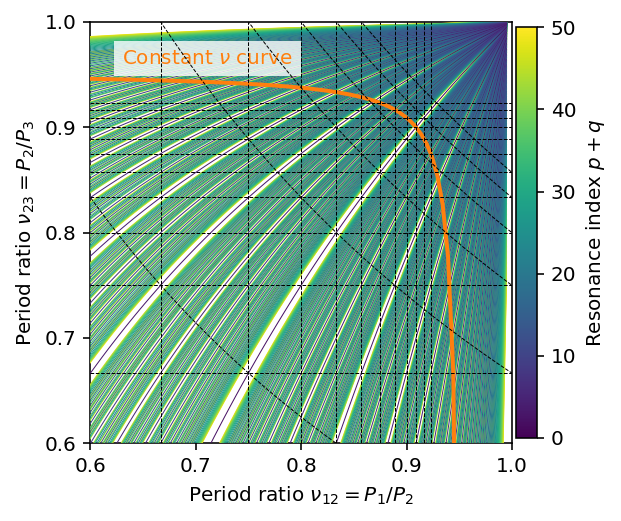

In [84]:
fig = plots.plot_zerothMMR_network(pqmax=50,nu=0.05)
fig.show()

# Overlap 

In [1420]:
A = 4/3*np.sqrt(34/pi)

In [1422]:
((3/2)*(.25)**3)**(1/8)*A**.25

0.9052420622494571

## Overlap on plane

In [133]:
#Initialize meshgrid
Npts =2000
nu12 = np.linspace(0.7,1,Npts)[:-1]
nu23 = nu12.copy()
Nu12,Nu23 = np.meshgrid(nu12,nu23)

#See eqs. (21,22)
Eta = Nu12*(1-Nu23)/(1-Nu12*Nu23)
Nu = 1/(1/(1/Nu12-1)+1/(1-Nu23))

masses = 1e-5*np.ones(3)

In [134]:
Overlap = overlap.overlap_plane(Nu12,Nu23,masses=masses,kmax=200)


In [67]:
Al12 = Nu12**(2/3)
Al23 = Nu23**(2/3)
m1,m2,m3 = masses
m0=1
Plsep = (1-Al12)*(1-Al23)/(2-Al12-Al23)
Mfac = (m1*m3/m0**2*(Eta**2/Al12**2+1+(1-Eta)**2*Al23**2))**.5

Overlap_th = Mfac*6.55*(Eta*(1-Eta))**1.5/Plsep**4 #(eq. 58)



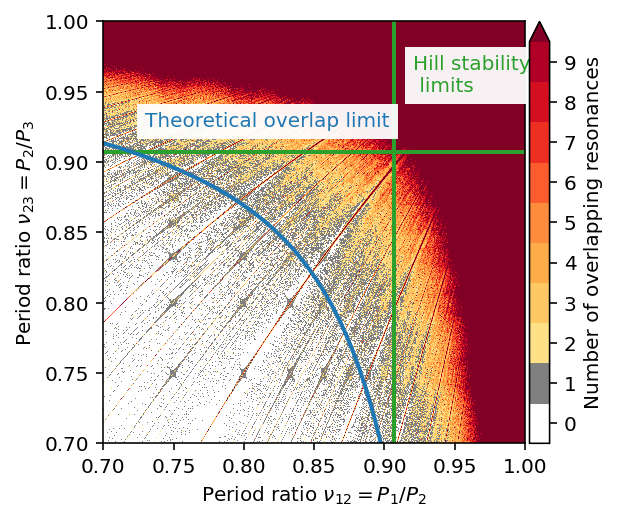

In [135]:
#Overlap zeroth order three planet MMR

fig = plots.plot_number_of_MMR(Nu12,Nu23,Overlap,masses)
fig.show()

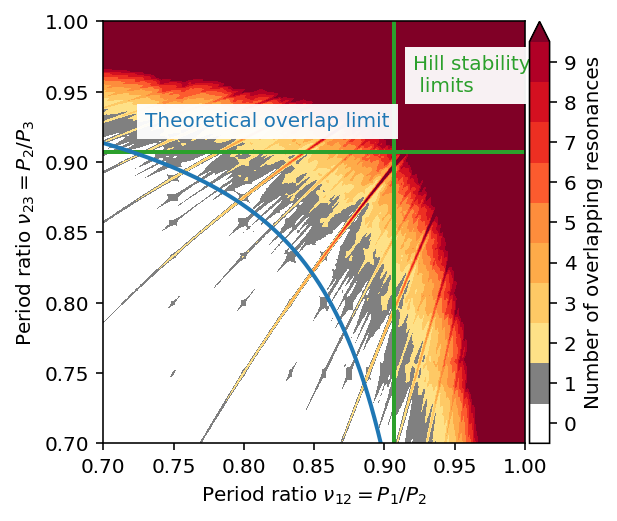

In [136]:
#Overlap zeroth order three planet MMR
#Smoothened version
Overlap_smoothened = ndimage.filters.gaussian_filter(Overlap,sigma=5)-.5 #.5 is here to account for shift of colorbar (centered on the integers)

fig = plots.plot_number_of_MMR(Nu12,Nu23,Overlap_smoothened,masses)
fig.show()

## Comparison Hill

In [1616]:
#Numerical coefficients from the article
A=np.sqrt(38/pi)
print("numfacfreq A",A)
Ares = 4*2**.5/3*A
print("numfacres",Ares)
print("Coeff equal space",(1.5)**.5*Ares**.25*(0.5**2)**(3/8))
print("Numerical coeff Ts/P1, then log10",32*pi*2**.5/3*A,np.log10(32*pi*2**.5/3*A))

numfacfreq A 3.477898169151024
numfacres 6.55798767915458
Coeff equal space 1.165375227151379
Numerical coeff Ts/P1, then log10 164.82020732131525 2.217010456087706


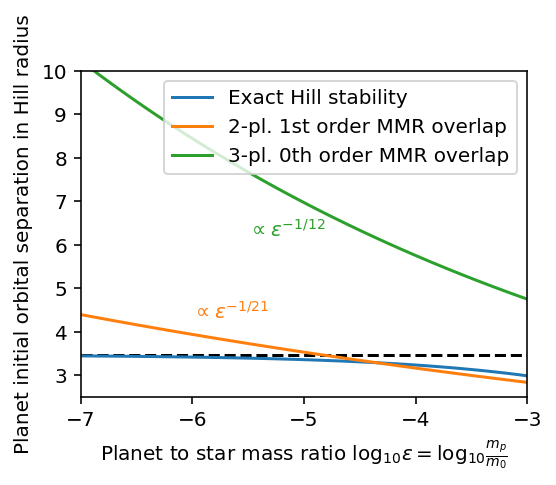

In [71]:
fig = plots.comparison_hill_radius()
fig.show()

# Diffusion timescale

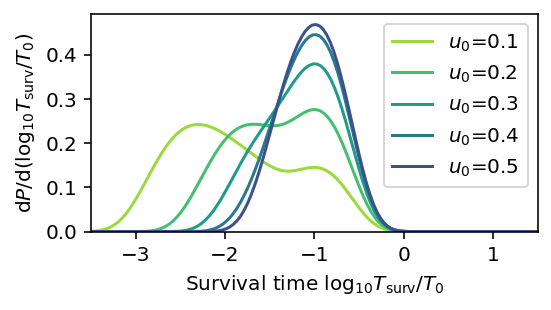

In [80]:
fig=plots.exittime_distribution()
fig.show()

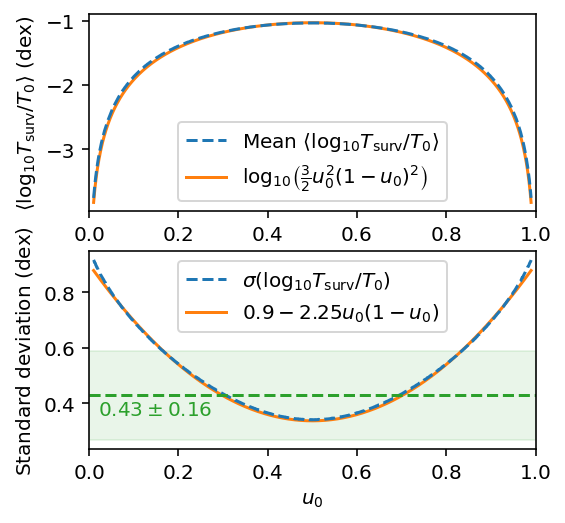

In [85]:
u0s=np.linspace(0.01,0.99,1000)
fig,means,stds = plots.mean_and_std_exittimes(u0s,fullres=True)

# Comparisons to numerical simulations

Text(0.5, 0, '$\\delta/\\delta_{\\mathrm{ov}}$')

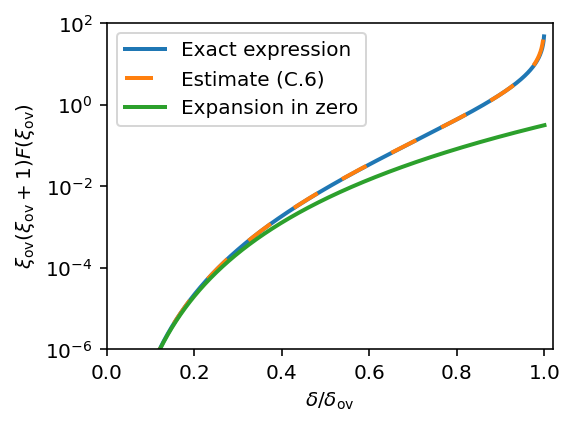

In [86]:
#Different estimates of times 
fig,ax=plt.subplots(figsize=(4,3))
dr = np.linspace(0,1,1000)[10:]
xiov = -1-sc.special.lambertw((-1+dr**4)/np.exp(1),-1).real
F = (1-sc.special.dawsn((xiov/2)**.5)/(xiov/2)**.5)**2
sTnorm = xiov*(xiov+1)*F
smTnorm = 2*2**.5/9*dr**6*10**(np.sqrt(-np.log(1-dr**4)))

plt.semilogy(dr,sTnorm,label='Exact expression',lw=2)
plt.semilogy(dr,smTnorm,'--',label='Estimate (C.6)',dashes=(7, 7),lw=2)
plt.semilogy(dr,2*2**.5/9*dr**6,label='Expansion in zero',lw=2)
plt.xlim(0,1.02)
plt.ylim(1e-6,1e2)
plt.legend()
plt.ylabel(r'$\xi_{\mathrm{ov}}(\xi_{\mathrm{ov}}+1)F(\xi_{\mathrm{ov}})$')
plt.xlabel(r'$\delta/\delta_{\mathrm{ov}}$')

In [100]:
#Import dataset
EMStimes1e7 = pd.read_csv('Tsurv_EMS_1e7.csv',index_col=0)
EMStimes1e5 = pd.read_csv('Tsurv_EMS_1e5.csv',index_col=0)
EMStimes1e3 = pd.read_csv('Tsurv_EMS_1e3.csv',index_col=0)
EMS_5pl_3e6_Obertas = pd.read_csv('EMS_5pl_3e6_Obertas.csv',index_col=0)

In [130]:
for mpl,df in zip([1e-7,1e-5,1e-3,3e-6],[EMStimes1e7,EMStimes1e5,EMStimes1e3,EMS_5pl_3e6_Obertas]):
    df['Tsurv'] = st.Tsurv(1/df.per_rat.values,1/df.per_rat.values,mpl*np.ones(3),res=False,fudge=1)
    df['Tsurvres'] = st.Tsurv(1/df.per_rat.values,1/df.per_rat.values,mpl*np.ones(3),res=True,fudge=1)
    df['alpha'] = df.per_rat**(-2/3)
    df['plsep'] = (1-df.alpha)/2
    
    df.Tsurv[df.Tsurv<0] = 1e13
    df.Tsurvres[df.Tsurvres<0] = 1e13
EMS_5pl_3e6_Obertas['Tsurv5'] = st.Tsurv(1/EMS_5pl_3e6_Obertas.per_rat.values,1/EMS_5pl_3e6_Obertas.per_rat.values,3e-6*np.ones(3),res=False,fudge=2)
EMS_5pl_3e6_Obertas.Tsurv5[EMS_5pl_3e6_Obertas.Tsurv5<0] = 1e13

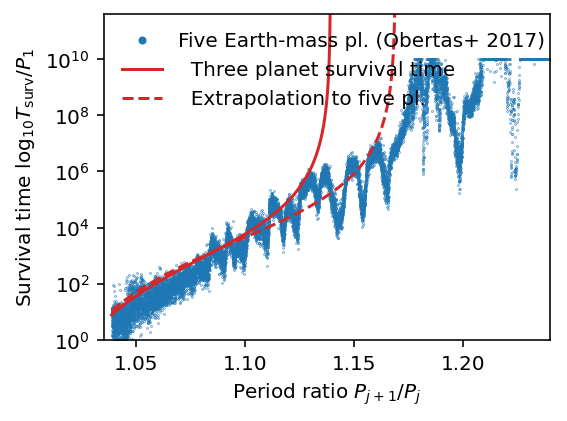

In [139]:

fig,ax = plt.subplots(figsize=(4,3))
plt.plot(EMS_5pl_3e6_Obertas.per_rat,EMS_5pl_3e6_Obertas.time,'.',ms=0.5,rasterized=True)
plt.plot([0,0],ls=' ',marker='o',ms=3,c='tab:blue',label="Five Earth-mass pl. (Obertas+ 2017)")
plt.semilogy(EMS_5pl_3e6_Obertas.per_rat,EMS_5pl_3e6_Obertas.Tsurv,
             c='tab:red',label="  Three planet survival time")
plt.semilogy(EMS_5pl_3e6_Obertas.per_rat,EMS_5pl_3e6_Obertas.Tsurv5,
             c='tab:red',ls='--',label="  Extrapolation to five pl.")
plt.ylim(1,4e11)
plt.xlabel(r'Period ratio $P_{j+1}/P_j$')
plt.ylabel(r'Survival time $\log_{10}T_{\mathrm{surv}}/P_1$')
plt.xlim(1.035,1.24)
plt.legend(loc=2,framealpha=0)

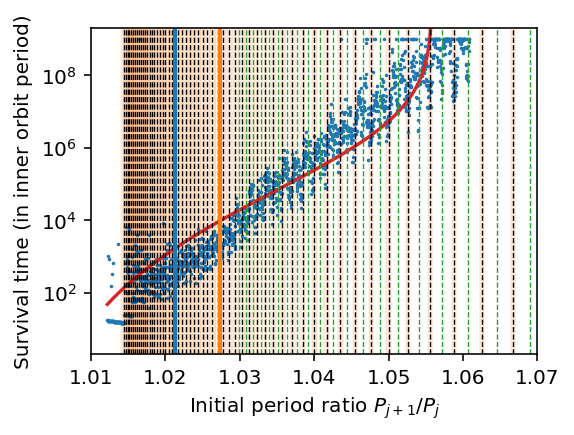

In [116]:
fig=plots.EMS_survtime(EMStimes1e7,mass=1e-7,range_perrat=(1.01,1.07),real_overlap=False)
fig.show()

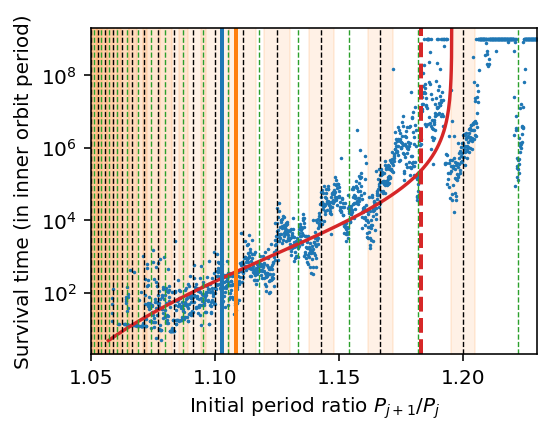

In [117]:
fig=plots.EMS_survtime(EMStimes1e5,mass=1e-5,range_perrat=(1.05,1.23),real_overlap=True)
fig.show()

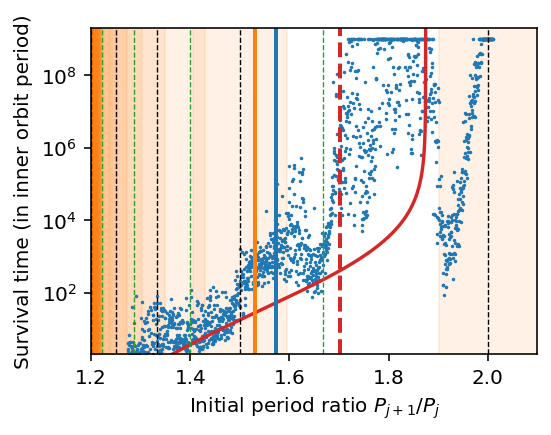

In [119]:
fig=plots.EMS_survtime(EMStimes1e3,mass=1e-3,range_perrat=(1.2,2.1),real_overlap=True)
fig.show()

# Laplace coefficients

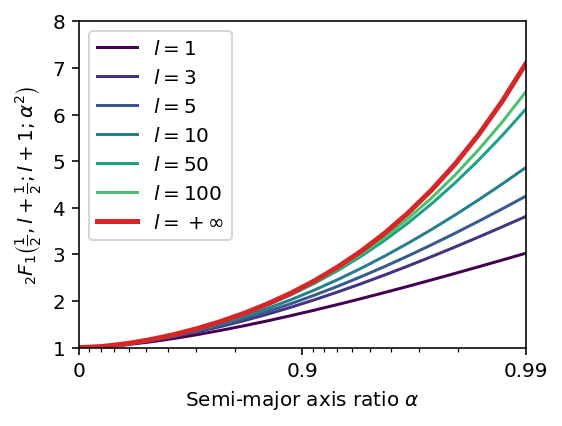

In [122]:
ks = np.logspace(0,3.5,100)
alphas = np.sort(1-np.logspace(-2,-0,20))
from scipy.special import hyp2f1,gamma,loggamma
fig,ax=plt.subplots(figsize=(4,3))
for j,k in enumerate([1,3,5,10,50,100]):
    plt.semilogx(1-alphas,hyp2f1(.5,k+.5,k+1,alphas**2),c=cm.viridis(j/7),label=fr'$l={k}$')
plt.semilogx(1-alphas,(1-alphas**2)**-.5,c='tab:red',lw=2.5,label=fr'$l=+\infty$')
plt.ylim(1,8)
ax.set_xlim(1,1e-2)
ax.set_xticklabels([0.9999,0.99,0.9,0])
ax.set_xlabel(r'Semi-major axis ratio $\alpha$')
ax.set_ylabel(r'${}_2F_1\left(\frac{1}{2},l+\frac{1}{2};l+1;\alpha^2\right)$')
plt.legend()

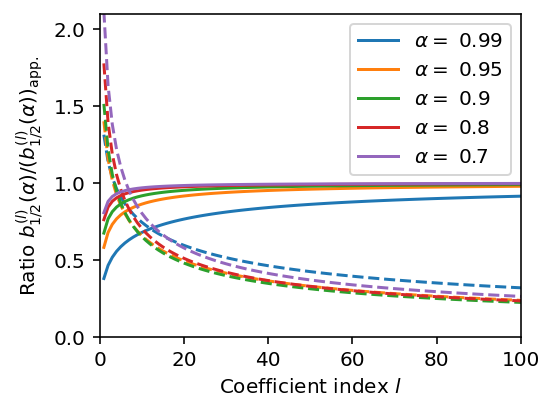

In [124]:
fig,ax = plt.subplots(figsize=(4,3))
#plt.yscale('log')
ps = np.linspace(1,100,100)

for k,delta in enumerate([0.01,0.05,0.1,0.2,0.3]):
    alpha=1-delta
    color = cm.tab10(k)
    plt.plot(ps,b_lap(0.5,ps,alpha)/(-0.5*np.log(delta)*alpha**(ps)),c=color,ls='--')
    plt.plot(ps,b_lap(0.5,ps,alpha)/(2/(pi*ps*(1-alpha**2))**.5*alpha**(ps)),c=color,label=rf"$\alpha =$ {alpha}")

ax.set_ylabel(r'Ratio $b^{(l)}_{1/2}(\alpha)/(b^{(l)}_{1/2}(\alpha))_{\mathrm{app.}}$')
ax.set_xlabel(r'Coefficient index $l$')
ax.set_xlim(0,100)
ax.legend(loc=1)
ax.set_ylim(0,2.1)
fig.tight_layout()